In [3]:
%load_ext autoreload
%autoreload 2

In [76]:
import os
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface as si
from dartsort.localize import localize_torch as loc

path_to_dataset = '/media/cat/data/noah/IBL_data_CEED/febb430e-2d50-4f83-87a0-b5ffbb9a4943/'
path2 = '/home/noah/code/CEED_new/CEED/notebooks/'

In [77]:
for root, dirs, files in os.walk(path_to_dataset):
    print(root)
    print(dirs)
    print(files)
    print('\n')

print('path2')
print('\n')

for root, dirs, files in os.walk(path2):
    print(root)
    print(dirs)
    print(files)
    print('\n') 

/media/cat/data/noah/IBL_data_CEED/febb430e-2d50-4f83-87a0-b5ffbb9a4943/
['properties', 'ds']
['_spikeglx_ephysData_g0_t0.imec0.ap.normalized.meta', 'probe.json', 'si_folder.json', 'binary.json', 'traces_cached_seg0.raw', 'provenance.json']


/media/cat/data/noah/IBL_data_CEED/febb430e-2d50-4f83-87a0-b5ffbb9a4943/properties
[]
['offset_to_uV.npy', 'contact_vector.npy', 'inter_sample_shift.npy', 'group.npy', 'location.npy', 'gain_to_uV.npy']


/media/cat/data/noah/IBL_data_CEED/febb430e-2d50-4f83-87a0-b5ffbb9a4943/ds
['covariances']
['labels_train.npy', 'channel_num_train.npy', 'labels_test.npy', 'spikes_val.npy', 'labels_val.npy', 'spikes_test.npy', 'channel_num_val.npy', 'channel_num_test.npy', 'channel_spike_locs_val.npy', 'channel_spike_locs_test.npy', 'spikes_train.npy', 'channel_spike_locs_train.npy']


/media/cat/data/noah/IBL_data_CEED/febb430e-2d50-4f83-87a0-b5ffbb9a4943/ds/covariances
[]
['temporal_cov.npy', 'spatial_cov.npy']


path2


/home/noah/code/CEED_new/CEED/notebooks/

In [78]:
# alternate data

# spikes_train = np.load(path_to_dataset + 'ds/' + 'spikes_train.npy')
# spikes_test = np.load(path_to_dataset + 'ds/' + 'spikes_test.npy')
# spikes_val = np.load(path_to_dataset + 'ds/' + 'spikes_val.npy')
# spikes = np.concatenate((spikes_train, spikes_test, spikes_val)) #not enough spikes!

# spikes.shape

In [79]:
#load recording
pathREC = r'/media/cat/data/noah/IBL_data_CEED/febb430e-2d50-4f83-87a0-b5ffbb9a4943/' #session 2
rec = si.read_binary_folder(pathREC)

In [80]:
geom = np.load(path2 + 'geom_sess2.npy')
templates = np.load(path2 + 'templates_sess2.npy')
spikes_idx = np.load(path2 + 'spike_idx_sess2.npy') #spike time, channel location of max channel, neuron id from spike sorting; for each spike
chans_idx = np.load(path2 + 'chan_idx_sess2.npy')

In [81]:
chans_idx.shape

(384, 40)

In [82]:
len(np.unique(spikes_idx[2]))

429

In [83]:
# spikes_val = np.load(path_to_dataset + 'ds/' + 'spikes_val.npy')
# spikes_train = np.load(path_to_dataset + 'ds/' + 'spikes_train.npy')
# spikes_test = np.load(path_to_dataset + 'ds/' + 'spikes_test.npy')
# spikes = np.concatenate((spikes_val, spikes_test, spikes_train)) #not enough spikes!


In [84]:
# print(spikes.shape)
# print(spikes_idx.shape)

In [85]:
#get amplitudes vector
amplitudes = rec.get_traces()[spikes_idx[0]] #use spike times as index to grab spikes amplitudes
print(amplitudes.shape) #spikes, channels. max amplitude of each spike on each channel

(159564, 384)


In [86]:
positions = spikes_idx[0]

spike_samples = []
for posit in positions:
    spike_samples.append(list(range(posit-43,posit+78)))
spike_samples = [item for sublist in spike_samples for item in sublist] 

# channels = spikes_idx[1]
# waveforms = rec.get_traces()[spikes_idx[0]][spikes_idx[1]]

In [87]:
#these two cells could be done in the same loop...

channel_indexs = spikes_idx[1] #need to extend each entry by 121 samples to match shape
channels_extended = []
for chan in channel_indexs:
    channels_extended.append([chan]*121)
channels_extended = [item for sublist in channels_extended for item in sublist]
    


In [88]:
waveforms = rec.get_traces()[spike_samples, channels_extended] #this is just the zero channel, need to take the best channel!!!!
#this finally works

In [89]:
print(waveforms.shape)
# reshape waveform array
waveforms = waveforms.reshape((159_564, 121))
print(waveforms.shape)

(19307244,)
(159564, 121)


In [90]:
# print(len(waveforms)/121)

In [91]:
# n=12000
# wave = waveforms[121*n:121*(n+1)]
# print(wave.shape)
# plt.plot(wave)
# plt.show()

In [92]:
#this method was way too memory intensive!!

#get waveforms
# 121 samples around the max amplitude
# # waveforms = np.empty((amplitudes.shape[0], 121, amplitudes.shape[1]))
# number_of_waves = 500
# waveforms = []
# for i, spike in enumerate(spikes_idx[0][0:number_of_waves]):
#     waveform = rec.get_traces()[spike-43:spike+78][:,spikes_idx[1][i]] #centre max peak of spike at sample 42
#     # waveforms[i] = rec.get_traces()[spike-42:spike+79]
#     waveforms.append(waveform)
# waveforms = np.asarray(waveforms)

42
(159564, 121)


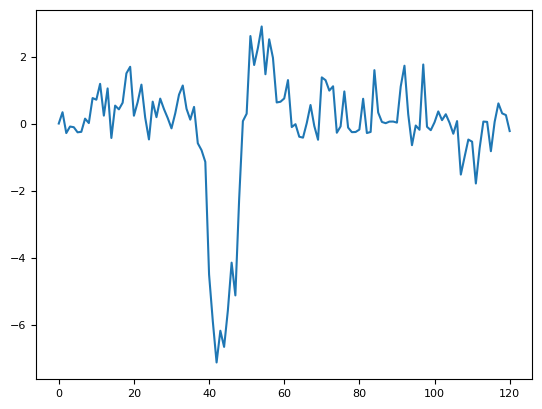

In [93]:
wave_no = 90
print(np.argmax(np.abs(waveforms[wave_no]))) #should be at 42
print(waveforms.shape) #waves should have length of 121
plt.plot(waveforms[wave_no])
plt.show()


In [94]:
#normalize between -1 and 1 !

def normalize_wf(wf):
    """Normalize waveform for use in cell type experiments.
    Parameters
    ----------
    wf: numpy.ndarray
        spike that has shape (n_chans, spike_length_samples)
    Returns
    -------
    waveform normalized to the range [0, 1] to retain shape information, but not amplitude information
    """
    if len(wf.shape) == 1:
        _ = wf.shape
        n_chans = None
    else:
        n_chans, _ = wf.shape
    wf = wf.flatten()
    if np.max(np.abs(wf), axis=0) != 0:
        wf /= np.max(np.abs(wf), axis=0)
    wf = wf.reshape(n_chans, -1) if n_chans is not None else wf
    return wf

# from sklearn.preprocessing import StandardScaler
# norm = StandardScaler()
# waveforms = norm.fit_transform(waveforms, y=None)




In [95]:
radius = 100 #microns #100 correct
num_spikes_st = 0
num_spikes = -1
main_chan = spikes_idx[1]
subset = None
locs = loc.localize_amplitude_vectors(amplitude_vectors = amplitudes[0:num_spikes], n_channels_subset = subset, geom = geom, main_channels = main_chan[0:num_spikes], radius = radius)


In [96]:
z = locs["z_abs"]
x = locs["x"]
pitch = 40

idx_good = np.flatnonzero(np.logical_and(
    np.logical_and(x > geom[:, 0].min()-pitch, x < geom[:, 0].max()+pitch),
    np.logical_and(z > geom.min()-pitch, z < geom.max()+pitch)))

x = x[idx_good]
z = z[idx_good]
index = spikes_idx[2][idx_good]
waveforms = waveforms[idx_good, :]
amplitudes = amplitudes[idx_good, :]

In [97]:
print(waveforms.shape)
print(amplitudes.shape)

(158167, 121)
(158167, 384)


In [26]:

import colorcet as cc
def get_ccolor(k):
    if k == -1:
        return "#808080"
    else:
        return ccolors[k % len(ccolors)]
# ccolors = cc.glasbey[:31]
ccolors = cc.glasbey[:50]

cols = [get_ccolor(idx) for idx in index]

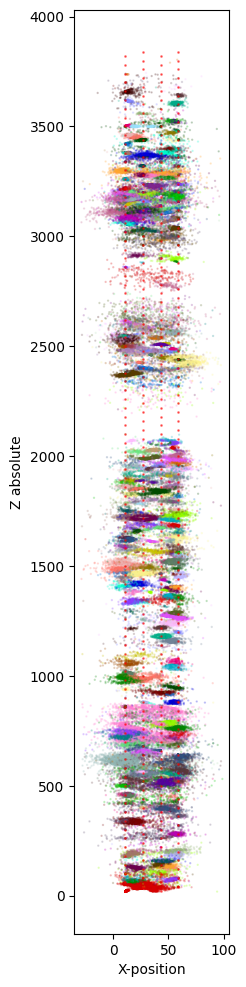

In [27]:
plt.figure(figsize=(2,12)) #2,12 is better tbh

plt.scatter(x, z, alpha=0.2, s = 0.5, c = cols) #coloured by neuron id, adds nothing but confirms things work!
plt.scatter(geom[:,0], geom[:,1], c='red', alpha=0.5, s=0.9)
plt.xlabel('X-position')
plt.ylabel('Z absolute')
#2x12
plt.show()

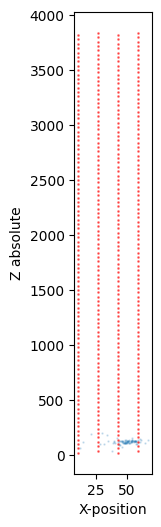

In [28]:
# spikes from one neuron, pretty good :)
neuronID = 5

x1 = x[index==neuronID]
z1 = z[index==neuronID]

plt.figure(figsize=(1,6)) #2,12 is better tbh

plt.scatter(x1, z1, alpha=0.2, s = 0.5) #coloured by neuron id, adds nothing but confirms things work!
plt.scatter(geom[:,0], geom[:,1], c='red', alpha=0.5, s=0.9)
plt.xlabel('X-position')
plt.ylabel('Z absolute')
#2x12
plt.show()

Whats with the x-direction smudge? Doesn't happen in z direction

# Make a useful dataset

In [29]:
#generating a single cell dataset with firing rate and predicting max fr from ceed embeddings.
# import pandas as pd

In [30]:
# single_cell_dataset = {spike_id: spike_id, spike_centre_waveform: spike_data, cluster: cluster_index, geometry: geo, channel_channelID}
#something liek this...

# CEED time

In [31]:
from ceed.models.ceed import CEED
import numpy as np
import os
import matplotlib.pyplot as plt
from analysis.projections import learn_manifold_umap, pca_train, pca
import colorcet as cc
import torch

from tqdm import tqdm

from mpl_toolkits.mplot3d import Axes3D

2023-11-16 18:32:40.194837: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-16 18:32:40.194873: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-16 18:32:40.194898: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-16 18:32:40.201042: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-16 18:32:41.173741: W tensorflow/compiler/

In [105]:
for i, wav in enumerate(waveforms):
    waveforms[i] = normalize_wf(wav)

In [33]:
fc_celltype_ckpt_dir = '/home/noah/code/400neur_200s_5d_celltype_fc_ckpt/'

fc_celltype_ceed_5d = CEED(num_extra_chans=0, out_dim=5, proj_dim=5, gpu=0, old_ckpt=True)
fc_celltype_ceed_5d.load(fc_celltype_ckpt_dir)

Using projector; batchnorm False with depth 3; hidden_dim=512
loading from previous checkpoint:  /home/noah/code/400neur_200s_5d_celltype_fc_ckpt/


In [34]:
print(waveforms.shape)
batch = 1
cells = waveforms.shape[0]
timepoints = waveforms.shape[1]

(158167, 121)


In [35]:
#convert to tensor, batch data for gpu, and send to gpu
waveforms = torch.from_numpy(waveforms.astype('float32')) #must be float32?
waveforms = waveforms.reshape(batch, int(cells/batch), timepoints)
# waveforms = waveforms.to('cuda') 

#put on the gpu in the inference loop?
#https://discuss.pytorch.org/t/dataset-location-runtimeerror-caught-runtimeerror-in-dataloader-worker-process-0/156842

print(waveforms.shape, waveforms.device)

torch.Size([1, 158167, 121]) cpu


In [36]:
idx_good

array([     0,      1,      2, ..., 159560, 159561, 159562])

In [37]:
embeddings_all = []
with torch.no_grad():
    for spike in tqdm(waveforms):
        # data = torch.unsqueeze(spike, dim=-1)
        spike.to('cuda')
        feature = fc_celltype_ceed_5d.transform(spike) #returns a np array
        embeddings_all.append(feature)
# embeddings_all = torch.concatenate(embeddings_all).to('cpu').detach().squeeze().numpy()
embeddings_all = np.asarray(embeddings_all).squeeze()

100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.05s/it]


In [38]:
embeddings_all.shape

(158167, 5)

In [39]:
#return waveforms to right shape!
waveforms = np.asarray(waveforms.squeeze())

In [40]:
# plt.figure(figsize=(1,6)) #2,12 is better tbh

# plt.scatter(x, z, alpha=0.2, s = 0.5, c = embeddings_all[:,0]) #coloured by neuron id, adds nothing but confirms things work!
# plt.scatter(geom[:,0], geom[:,1], c='red', alpha=0.5, s=0.9)
# plt.xlabel('X-position')
# plt.ylabel('Z absolute')
# #2x12
# plt.show()

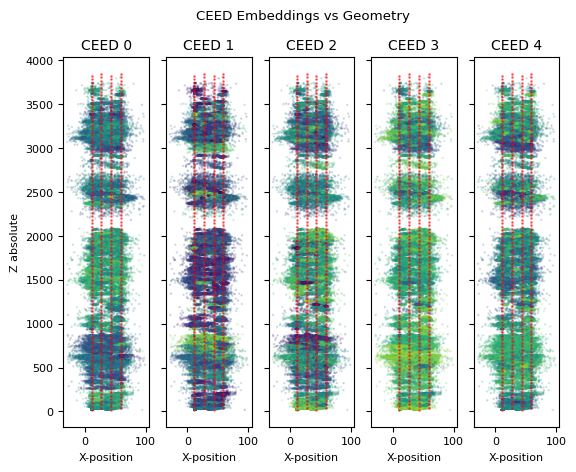

In [41]:
def qplot(i):
    ax[i].scatter(x, z, alpha=0.2, s = 0.5, c = embeddings_all[:,i])
    ax[i].scatter(geom[:,0], geom[:,1], c='red', alpha=0.5, s=0.9)
    ax[i].set_xlabel('X-position')
    if i == 0:
        ax[i].set_ylabel('Z absolute')
    title = 'CEED ' + str(i)
    ax[i].set_title(title)
    # ax[i].set_ylim(0,1000)
    # ax[i].axis('equal')
    # ax[i].set_xlim(-1,1)

fig, ax = plt.subplots(1,5, sharey = True)
fig.suptitle('CEED Embeddings vs Geometry', fontsize='large')

for i in range(5):
    qplot(i)

# fig.colorbar(ax[4], cax=embeddings_all[:,4])
# plt.colorbar(fig)
plt.show()


In [42]:
# should do this as a 3d plot instead

In [43]:
neuronID = 7
neuronID2 = 70

mask = np.logical_or(index==neuronID, index==neuronID2)

x1 = x[mask]

z1 = z[mask]

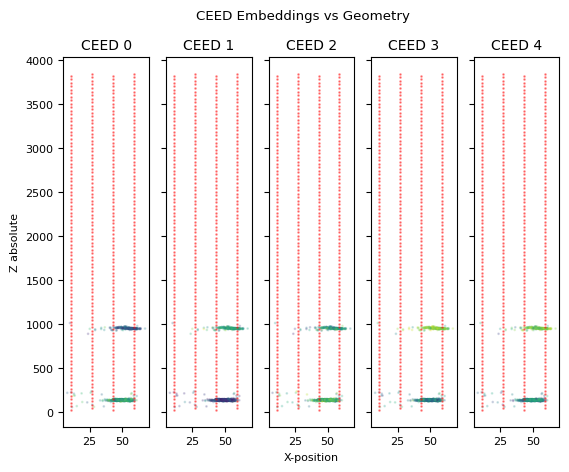

In [44]:
def qplot(i):
    ax[i].scatter(x1, z1, alpha=0.2, s = 0.9, c = embeddings_all[mask,i])
    ax[i].scatter(geom[:,0], geom[:,1], c='red', alpha=0.4, s=0.8)
    if i ==2:
        ax[i].set_xlabel('X-position')
    if i == 0:
        ax[i].set_ylabel('Z absolute')
    title = 'CEED ' + str(i)
    ax[i].set_title(title)


fig, ax = plt.subplots(1,5, sharey = True)
fig.suptitle('CEED Embeddings vs Geometry', fontsize='large')

for i in range(5):
    qplot(i)

# fig.colorbar(ax[4], cax=embeddings_all[:,4])
# plt.colorbar(fig)
plt.show()

#need to update colour map and add a colour bar

In [45]:
print(embeddings_all[neuronID])
print(embeddings_all[neuronID2])

[-0.44544473 -0.41025284 -0.53381366  0.5880646   0.04994576]
[-0.026657   -0.85331666 -0.42263114  0.09820351 -0.2878871 ]


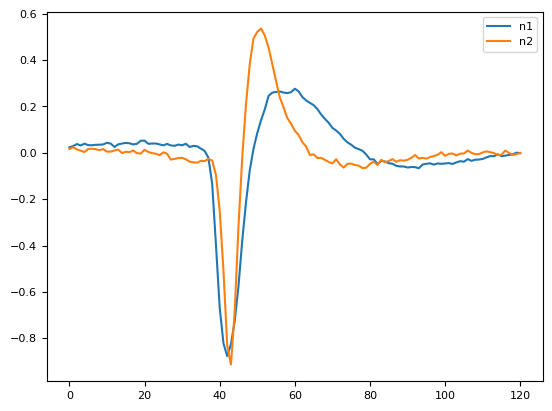

In [46]:
plt.plot(np.mean(waveforms[index==neuronID], 0), label='n1')
plt.plot(np.mean(waveforms[index==neuronID2], 0), label='n2')
plt.legend()
plt.show()

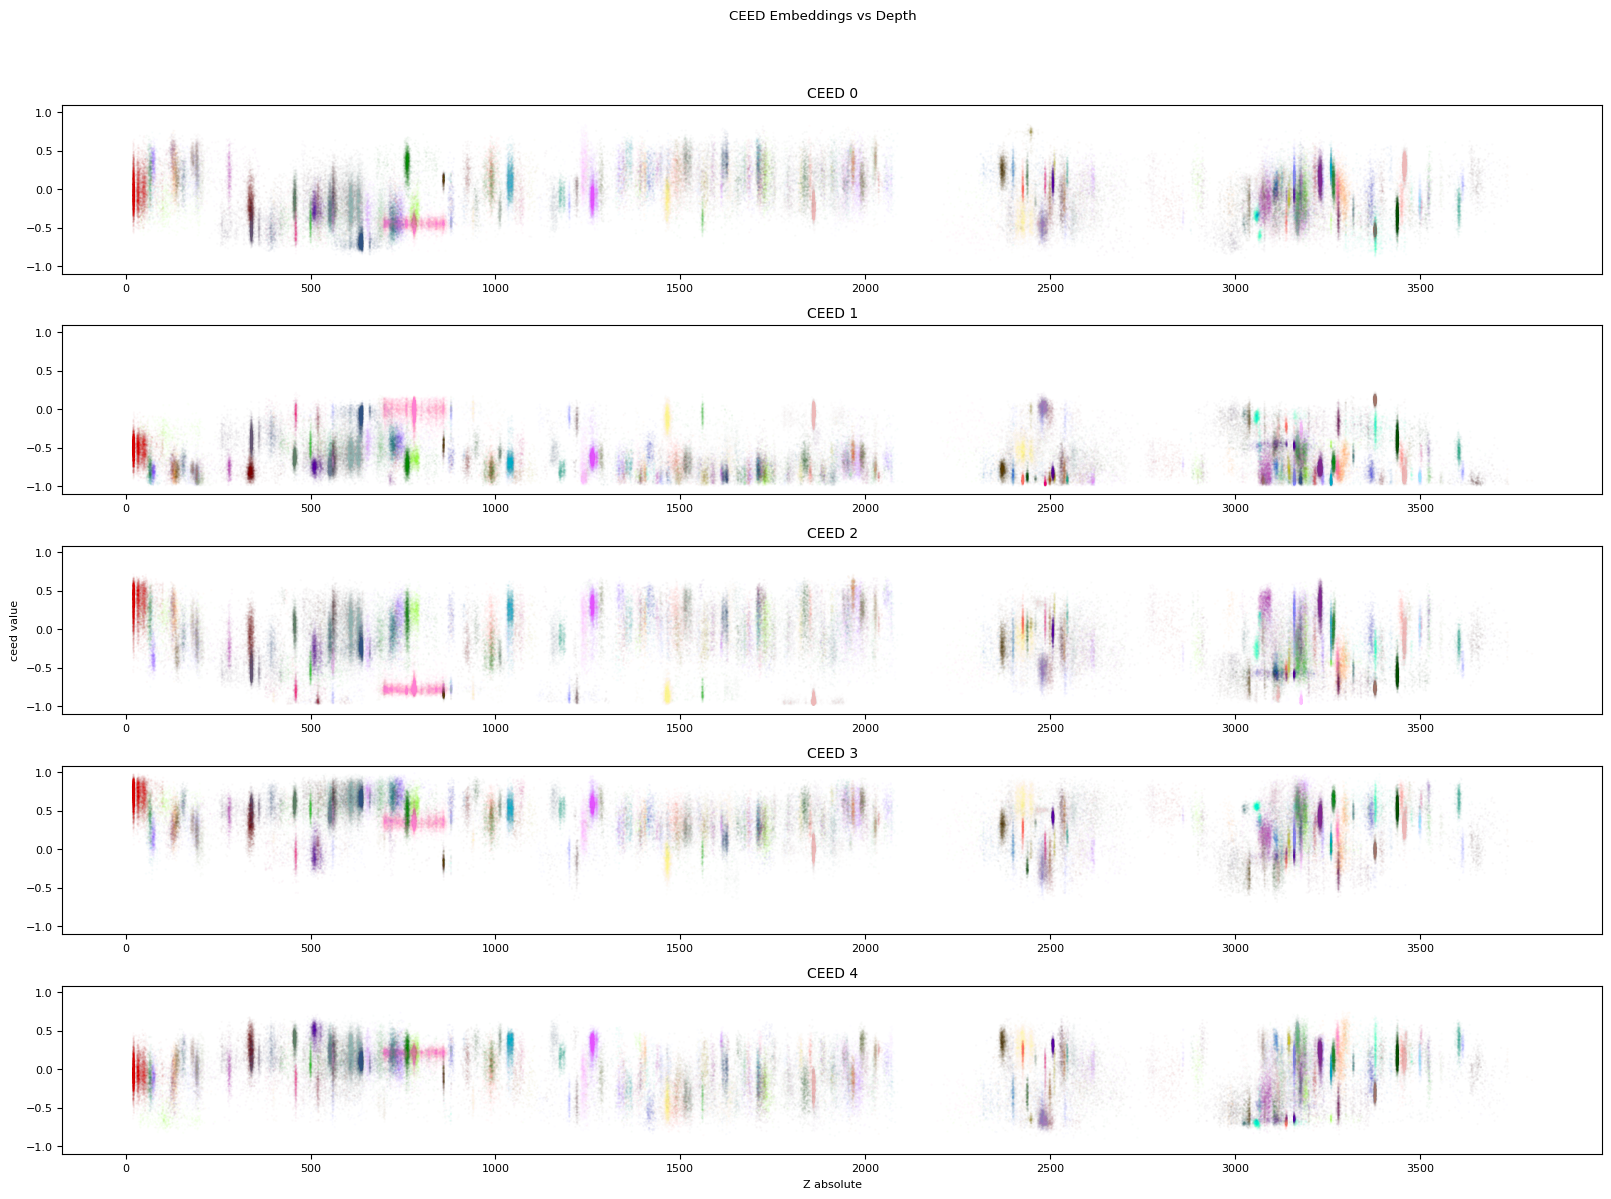

In [47]:
def qplot2(i):
    ax[i].scatter(z, embeddings_all[:,i], alpha=0.02, s = 0.5, c = cols)
    if i ==2:
        ax[i].set_ylabel('ceed value')
    if i == 4:
        ax[i].set_xlabel('Z absolute')
    title = 'CEED ' + str(i)
    ax[i].set_title(title)
    

fig, ax = plt.subplots(5,1, sharey = True, figsize=(16, 12))
fig.tight_layout(h_pad=3)
plt.subplots_adjust(top=0.9)
fig.suptitle('CEED Embeddings vs Depth', fontsize='large')

for i in range(5):
    qplot2(i)

# fig.colorbar(ax[4], cax=embeddings_all[:,4])
# plt.colorbar(fig)
plt.show()

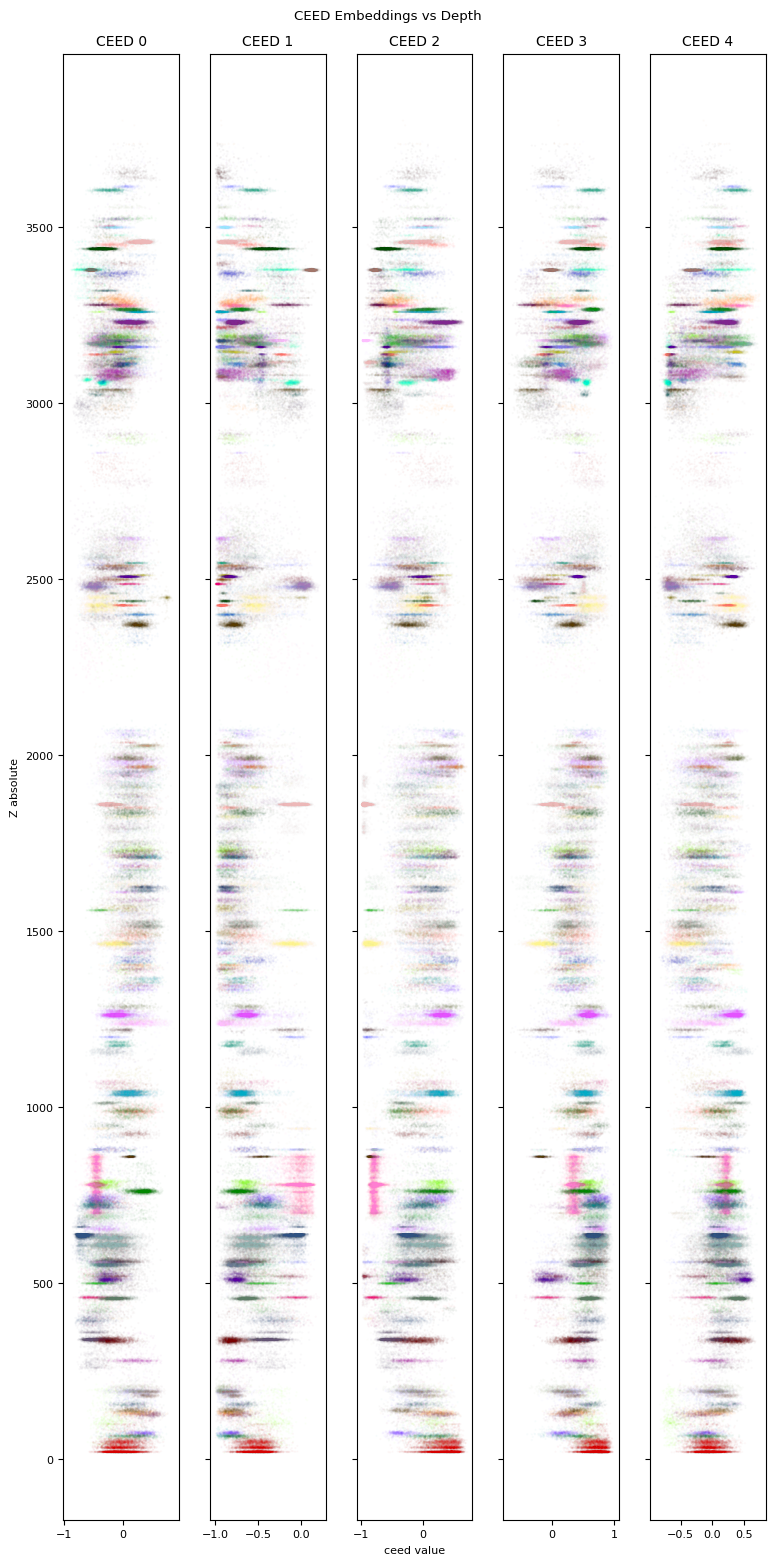

In [48]:
def qplot2(i):
    ax[i].scatter(embeddings_all[:,i], z, alpha=0.02, s = 0.5, c = cols)
    if i ==2:
        ax[i].set_xlabel('ceed value')
    if i == 0:
        ax[i].set_ylabel('Z absolute')
    title = 'CEED ' + str(i)
    ax[i].set_title(title)
    

fig, ax = plt.subplots(1,5, sharey = True, figsize=(8, 16))
# plt.subplots_adjust(top=5.85)
fig.suptitle('CEED Embeddings vs Depth', fontsize='large')

for i in range(5):
    qplot2(i)
fig.tight_layout(pad=2)

# fig.colorbar(ax[4], cax=embeddings_all[:,4])
# plt.colorbar(fig)
plt.show()

In [49]:
#need to weight these plots somehow, like a histogram...

In [22]:
from dartsort.config import FeaturizationConfig
from dartsort.transform import WaveformPipeline
from dartsort import transform
from dartsort.util.waveform_util import make_channel_index
from dartsort.peel.grab import GrabAndFeaturize
from dartsort.util.data_util import DARTsortSorting

In [6]:
rec

BinaryFolderRecording: 384 channels - 30.0kHz - 1 segments - 30,000,000 samples 
                       1,000.00s (16.67 minutes) - float32 dtype - 42.92 GiB

In [7]:
spikes_idx

array([[    410,     574,     623, ..., 3599928, 3599981, 3599996],
       [    298,     317,      90, ...,      45,      33,     237],
       [    266,     292,      67, ...,      24,      16,     208]])

In [8]:
import torch

In [28]:
rec.get_traces(0, 0, 1000)

array([[ 0.01258725,  0.0033129 , -0.01371997, ..., -0.0163412 ,
        -0.02688869, -0.02866197],
       [ 0.04713967,  0.96385396,  0.02603926, ...,  0.09907912,
         0.08419678,  0.08268948],
       [ 1.7000802 ,  0.61430204,  2.3749323 , ..., -0.6327406 ,
         1.3270545 , -0.6425641 ],
       ...,
       [-0.68138564,  0.24750008, -0.77789366, ...,  0.68563473,
        -1.2214378 , -0.2663722 ],
       [-0.32336262, -0.30676755, -0.3745461 , ..., -0.32691225,
        -0.3410089 , -0.33609173],
       [-0.4094047 , -0.3802952 , -1.4892756 , ..., -1.7207141 ,
         0.17346302,  1.9971391 ]], dtype=float32)

In [ ]:
!rm -f 

In [12]:
geom = torch.as_tensor(rec.get_channel_locations())
channel_index = torch.as_tensor(make_channel_index(geom, 100))

pipeline = WaveformPipeline([
    transform.SingleChannelWaveformDenoiser(channel_index),
    transform.Localization(channel_index=channel_index, geom=geom, radius=100.),
    transform.MaxAmplitude(),
])

grabber = GrabAndFeaturize(
    rec,
    channel_index=torch.as_tensor(channel_index),
    featurization_pipeline=pipeline,
    times_samples=torch.as_tensor(spikes_idx[0]),
    channels=torch.as_tensor(spikes_idx[1]),
)

In [34]:
spikes_idx[0][[0,-1]]

array([    410, 3599996])

In [43]:
3599996 / 30_000

119.99986666666666

In [44]:
rec

BinaryFolderRecording: 384 channels - 30.0kHz - 1 segments - 30,000,000 samples 
                       1,000.00s (16.67 minutes) - float32 dtype - 42.92 GiB

In [13]:
from pathlib import Path

In [14]:
grabber.load_or_fit_and_save_models(Path(path2) / "grabmodels")

In [30]:
1

1

In [42]:
grabber.peel(Path(path2) / "grab.h5", n_jobs=2, overwrite=True)

Grab and featurize 1.0s/batch [spk/batch=159.6]: 100%|█| 1000/1000 [05:04<00:00,


PosixPath('/home/noah/code/CEED_new/CEED/notebooks/grab.h5')

In [45]:
!h5ls /home/noah/code/CEED_new/CEED/notebooks/grab.h5

amplitudes               Dataset {159564/Inf}
channel_index            Dataset {384, 18}
channels                 Dataset {159564/Inf}
geom                     Dataset {384, 2}
last_chunk_start         Dataset {SCALAR}
point_source_localizations Dataset {159564/Inf, 4}
sampling_frequency       Dataset {SCALAR}
times_samples            Dataset {159564/Inf}
times_seconds            Dataset {159564/Inf}


In [46]:
spikes = DARTsortSorting.from_peeling_hdf5('/home/noah/code/CEED_new/CEED/notebooks/grab.h5')

In [47]:
spikes.amplitudes

array([14.844289 ,  9.269184 ,  7.063836 , ...,  2.3211327,  3.094873 ,
        3.0535374], dtype=float32)

In [48]:
x, y, z, a = spikes.point_source_localizations.T

In [53]:
z

array([3056.66031866, 3151.17510235,  903.47156008, ...,  420.88166798,
        320.34544723, 2367.32002273])

In [ ]:
geom[:,

In [59]:
z

array([3056.66031866, 3151.17510235,  903.47156008, ...,  420.88166798,
        320.34544723, 2367.32002273])

In [60]:
np.clip(z, geom[:,1].min() - 100, geom[:,1].max() + 100)

tensor([3056.6603, 3151.1751,  903.4716,  ...,  420.8817,  320.3454,
        2367.3200], dtype=torch.float64)

In [63]:
valid = z == np.clip(z, geom[:,1].numpy().min() - 100, geom[:,1].numpy().max() + 100)
valid &= x == np.clip(x, geom[:,0].numpy().min() - 100, geom[:,0].numpy().max() + 100)


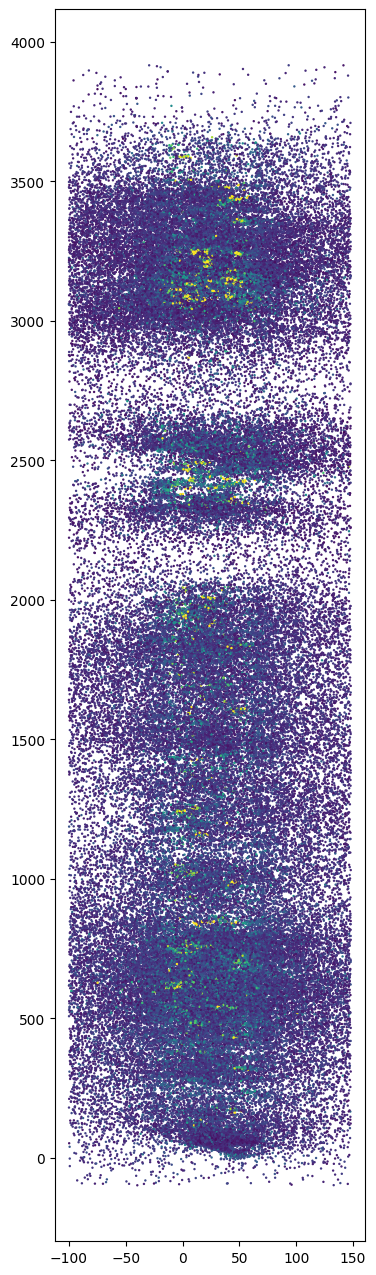

In [66]:
plt.figure(figsize=(4,16))
plt.scatter(x[valid], z[valid], c=np.minimum(spikes.amplitudes[valid], 15), s=3, lw=0)

In [98]:
waveforms.shape

(158167, 121)

# Han stuff

In [106]:
def peak_tip_trough(waveforms, peak_T):
    N, T = waveforms.shape
    peak_val = waveforms[:, peak_T]
    before_peak_wfs = waveforms[:,0:420]*np.sign(peak_val)[:, None]
    tip_idx = np.argmin(before_peak_wfs, 1)
    tip_val = before_peak_wfs[np.arange(N), tip_idx]*np.sign(peak_val)
    after_peak_wfs = waveforms[:,peak_T:T]*np.sign(peak_val)[:, None]
    trough_idx = np.argmin(after_peak_wfs, 1)
    trough_val = after_peak_wfs[np.arange(N), trough_idx]*np.sign(peak_val)

    return peak_val, tip_idx, tip_val, trough_idx+peak_T, trough_val

In [107]:
han_features = peak_tip_trough(waveforms, 42)

In [108]:
# han_features = [peak_tip_trough(wave, 42) for wave in waveforms]

In [109]:
len(han_features)

5

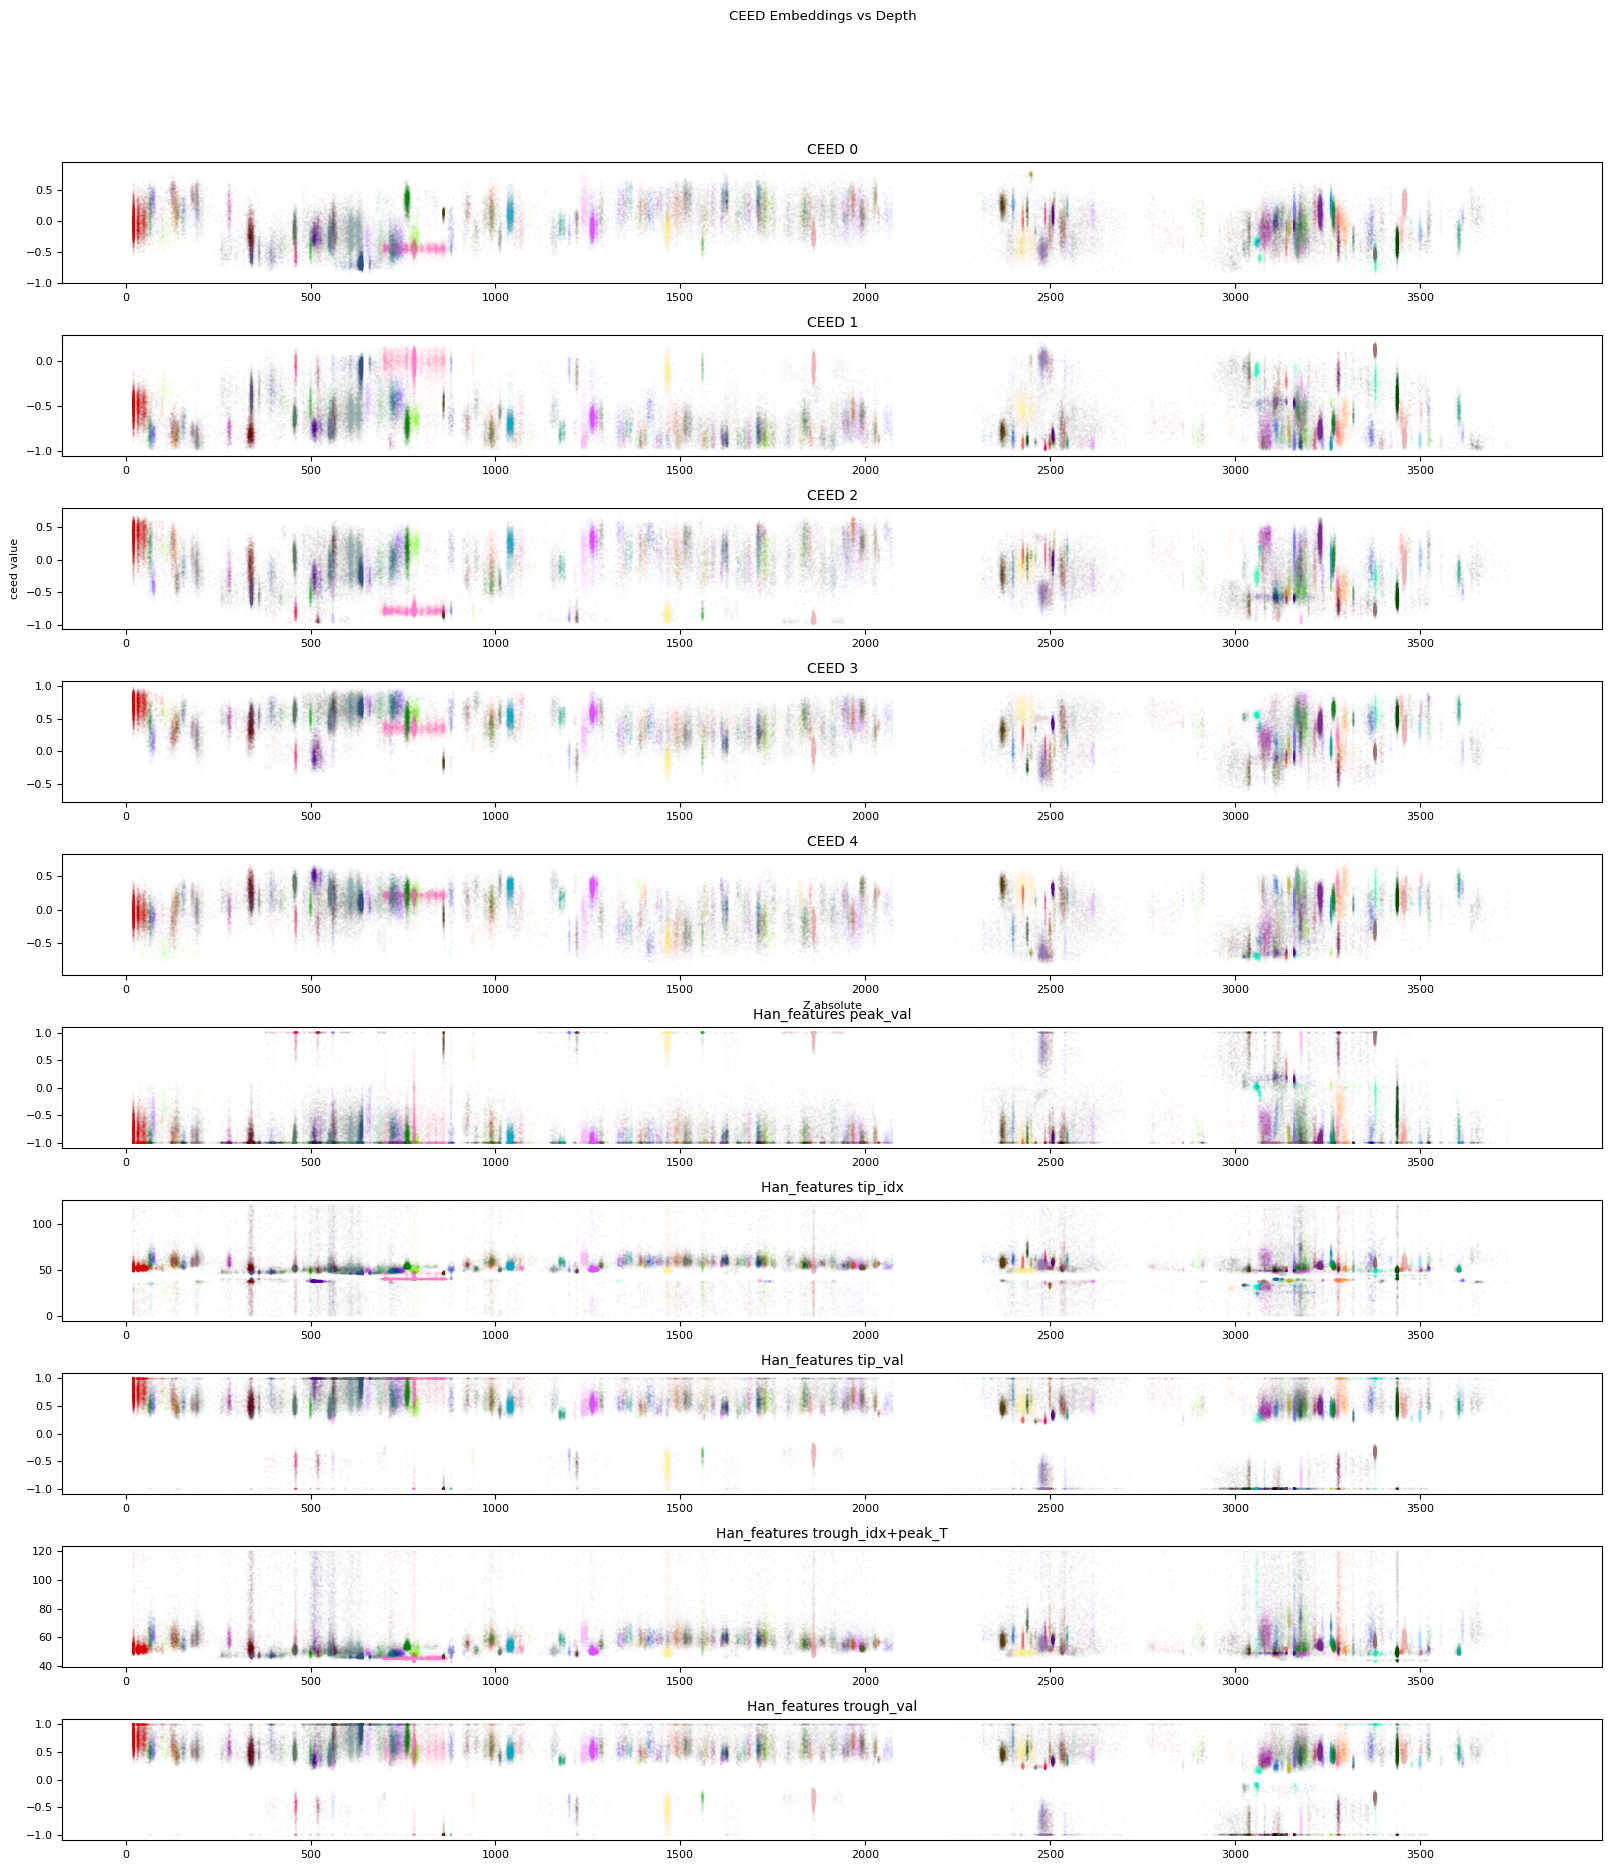

In [110]:
def qplot2(i):
    ax[i].scatter(z, embeddings_all[:,i], alpha=0.02, s = 0.5, c = cols)
    if i ==2:
        ax[i].set_ylabel('ceed value')
    if i == 4:
        ax[i].set_xlabel('Z absolute')
    title = 'CEED ' + str(i)
    ax[i].set_title(title)

def qplot_han(i):
    titles = ['peak_val', 'tip_idx', 'tip_val', 'trough_idx+peak_T', 'trough_val']
    ylab = str(titles[i-5])
    ax[i].scatter(z, han_features[i-5], alpha=0.02, s = 0.5, c = cols)
    if i ==2:
        ax[i].set_ylabel(ylab)
    if i == 4:
        ax[i].set_xlabel('Z absolute')
    title = 'Han_features ' + ylab
    ax[i].set_title(title)    
        
    

fig, ax = plt.subplots(10,1, sharey = False, figsize=(16, 19))
fig.tight_layout(h_pad=3)
plt.subplots_adjust(top=0.9)
fig.suptitle('CEED Embeddings vs Depth', fontsize='large')

for i in range(5):
    qplot2(i)
for i in range(5,10):
    qplot_han(i)

# fig.colorbar(ax[4], cax=embeddings_all[:,4])
# plt.colorbar(fig)
plt.show()

In [ ]:
aligned_wfs = align_spikes(temps_all)
wavemap_input = aligned_wfs/np.nanmax(np.abs(aligned_wfs),1)[:,None]

def align_spikes(wfs):
# input: waveforms of shape NxT
# upsample the waveform in time first for finer scale alignment
# then downsample the waveform to its original shape
    N, T = np.shape(wfs)
    upsampled_wfs = signal.resample(wfs, 10*T, axis = 1)
    aligned_wfs = np.zeros([N, 2500]) 
    peak_idx = 1050 # a value that is larger than all peak index values
    peak_point = np.argmax(np.absolute(upsampled_wfs), axis =1)    
    shift = peak_idx - peak_point

    for i in range(len(shift)):
        try:
            aligned_wfs[i, shift[i]:(shift[i] + 10*T)] = upsampled_wfs[i,:]
        except:
            print(i)
        
    return  signal.resample(aligned_wfs[:,630:(630+1210 + 1)], T, axis = 1)

In [111]:
#save this data and run hdbscan

#get hans features!
#denoised first

#ptT, ptp shoulder, 

# To do:

Han stuff - add to cell typre plots

Get spike sprting ceed wokring and repeat comparison

run hdbscan on these embeddings

start again using grab and featurize from charlie's code

In [ ]:
#better colours:

import colorcet as cc
colours = cc.glasbey_category10[0:50]
print(len(index))

In [ ]:
len(np.unique(index))

In [ ]:
colours = [colours[i] for i in index]

In [ ]:
channels_ = spikes_maybe[1]

In [ ]:
#single channel, would be great to have multi channel

In [ ]:
spikes_maybe #spike times, channel location of max channl, neuron id form spike sortin

In [ ]:
#

In [ ]:
print(chans.shape)
print(channel_num.shape)
print(spike_locs.shape)
print(spikes.shape)
print(geom.shape)
print(templates.shape)
print(spikes_maybe.shape)

In [ ]:
amp_vecs = np.max(templates, axis=1)
amp_vecs.shape

In [ ]:
channel_num[90]

In [ ]:
spike_locs.shape #unit, channel, geometric_location

In [ ]:
spike_locs[0] #x, depth

print(np.max(spike_locs[:2000,0,0]) - np.min(spike_locs[:2000,0,0])) #

In [ ]:
# plt.scatter(spike_locs[:,0,0], spike_locs[:,0,1],)
# plt.show()

In [ ]:
# plt.plot(spike_locs[:2000,0,0])

In [ ]:
geom.shape

In [ ]:
# plt.scatter(geom[:,1], geom[:,0])

In [ ]:
# geom[:,0]

In [ ]:
# looking at spikes

spikes.shape #template, channel, time

In [ ]:
plt.plot(spikes[9040,0,:])
plt.show()

In [ ]:
# fig, axs = plt.subplots(1,2, figsize=(12,4))
spikes_ = spikes[labels==6,10,:].T #why transpose??
print(spikes_.shape)
axs[0].plot(np.mean(spikes_,1))

axs[1].plot(spikes_[:,10])
plt.show() #why is the 10th channel always the best??

In [ ]:
mask = [labels == 4]
mask = [labels == 3]
mask

In [ ]:
groups = []
for label in np.unique(labels):
    mask = labels == label
    spike_group = np.asarray(spikes)[mask]
    groups.append(spike_group)
plt.plot(np.mean(spike_group[:,10,:],axis =0))
plt.show()


# spikes_ = spikes[labels==4,8,:].T #why transpose??
# spike_group.shape

In [ ]:
groups[0].shape 

#what channel should be used! channel id!! :)

In [ ]:
plt.plot(groups[1][9][15])
plt.show()

In [ ]:
templates.shape

In [ ]:
plt.plot(templates[7,:,0:33])#32 seems to be last channel with any signal
plt.show()

In [ ]:
#actual spike data looks terrible

#actual spikes
unq_labels = np.unique(labels)
means = np.empty((len(unq_labels), 121))
for i, label in enumerate(unq_labels):
    mask = np.array([labels == label]).flatten()
    spikes_label = spikes[:,3,:][mask] #channel could be ther problem here... need to fix that
    mean = np.mean(spikes_label, axis=0)
    means[i] = mean


In [ ]:
plt.plot(spikes_label[0])

In [ ]:
plt.plot(means[167])
plt.show()

In [ ]:
plt.plot(np.mean(spikes[spikes[labels==3,8,:]

In [ ]:
#ceed embedding performance in cell typeing and spike sorting compared to baseline

# TODO:

firing rate, depth, geometry of indiviudal spikes compared to templates, coloured by ceed embeddings
max firing rate is a proxy for cell types - interneurons fire far faster than exitatory

try a ps-vae?

localisation code

In [ ]:
#generating a single cell dataset with firing rate and predicting max fr from ceed embeddings.
import pandas as pd

In [ ]:
single_cell_dataset = {spike_id: spike_id, spike_centre_waveform: spike_data, cluster: cluster_index, geometry: geo, channel_channelID}





In [ ]:
amplitudes.argmax(axis =1)
print(amplitudes.shape)
print(geom.shape)

In [ ]:
np.isnan(amplitudes).any()

In [ ]:
np.min(amplitudes)

In [ ]:
main_chan = np.abs(amplitudes).argmax(axis=1)
main_chan = spikes_maybe[1]

In [ ]:
radius = 50 #microns #100 correct
num_spikes_st = 0
num_spikes = -1
# main_chan = np.ones(len(amplitudes))*10 #this is bad
# main_chan = amplitudes.argmax(axis =1)
subset = None
locs = loc.localize_amplitude_vectors(amplitude_vectors = amplitudes[0:num_spikes], n_channels_subset = subset, geom = geom, main_channels = main_chan[0:num_spikes], radius = radius)



In [ ]:
z = locs['z_abs']
x = locs["x"]

In [ ]:
locs.keys()

In [ ]:
pitch = 40

idx_good = np.flatnonzero(np.logical_and(
    np.logical_and(x > geom[:, 0].min()-pitch, x < geom[:, 0].max()+pitch),
    np.logical_and(z > geom.min()-pitch, z < geom.max()+pitch)))

x = x[idx_good]
z = z[idx_good]
# z_reg = z_reg[idx_good]
# maxptps = maxptps[idx_good]
# spt = spt[idx_good]

In [ ]:
plt.figure(figsize=(2,12))

plt.scatter(x, z, alpha=0.3, s = 0.7)
plt.scatter(geom[:,0], geom[:,1], c='red', alpha=0.5, s=0.9)
#2x12
plt.show()

In [ ]:
#colour code polts by ceed features

In [ ]:
#depth by ceed plot

In [ ]:
from ceed.models.ceed import CEED
import numpy as np
import os
import matplotlib.pyplot as plt
from analysis.projections import learn_manifold_umap, pca_train, pca
import colorcet as cc
import torch

from mpl_toolkits.mplot3d import Axes3D

In [ ]:
fc_celltype_ckpt_dir = '/home/noah/code/400neur_200s_5d_celltype_fc_ckpt/'

fc_celltype_ceed_5d = CEED(num_extra_chans=0, out_dim=5, proj_dim=5, gpu=0, old_ckpt=True)
fc_celltype_ceed_5d.load(fc_celltype_ckpt_dir)

In [ ]:
# help(CEED)

In [ ]:
#convert to tensor, batch data for gpu, and send to gpi
spikes_tensor = torch.from_numpy(spike_data.astype('float32')) #must be float32?
sample_data_tensor = sample_data_tensor.reshape(batch, int(cells/batch), timepoints)
sample_data_tensor = sample_data_tensor.to('cuda')
print(sample_data_tensor.shape, sample_data_tensor.device)

In [ ]:
#waveforms:

wavs = rec.get_traces()

In [ ]:
wavs[0].shape

In [ ]:
spikes_maybe[0]

In [ ]:
# checkpoint_path = '/home/noah/code/400neur_200s_5d_celltype_fc_ckpt'

# # fc_celltype_ckpt_dir = '/media/cat/data/CEED_celltype/400neur_200s_5d_celltype_fc_ckpt/'

# fc_celltype_ceed_5d = CEED(num_extra_chans=0, out_dim=5, proj_dim=5)
# fc_celltype_ceed_5d.load(fc_celltype_ckpt_dir)#this is for transformer model!

In [ ]:
# start running some inference:




In [ ]:
templates.shape

In [ ]:
chans.shape

In [ ]:
geom.shape

In [ ]:
amplitude_vecotors = #shape is number of spikes and number of channels it was recorded on

In [ ]:
chans.shape

In [ ]:
spike_locs[0]

In [ ]:
channel_num.shape #amp_vector

In [ ]:
#convert templates to amplitude vectors


In [ ]:
#ceed embed these, cluster, then plot cluster with location

# TODO 3rd nov:

PSVAE with handpicked features, also try to find the most linear way to go from embeddings to waveform (PCA)
Try to predict the multichannel waveform from just the single channel embedding with spatial location 

try to predict spatial location from waveform (depth). CEED embeddings and depth

### also, look at optotagging with neuropixel for cell typing
### keep thinking about 2p with neuropixel